In [2]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
pi = math.pi

In [3]:
#Setup initial forward simulation
S_init = np.array([0, 0, pi/2])
U = np.array([1, -1/2])
P_init = np.array([np.concatenate((S_init, U), axis=None)])

#Forward iteration for P0 (semi-circle initial guess)
T_STEPS = 100
dt = 2*pi/T_STEPS
t_array = np.zeros(T_STEPS)
for i in range(T_STEPS):
    t_array[i] = i*dt

P0 = np.zeros((T_STEPS, 5))
P0[0] = P_init
for i in range(T_STEPS-1):
    Sdot = np.array([U[0]*math.cos(P0[i][2]), U[0]*math.sin(P0[i][2]), U[1]])*dt
    S_new = P0[i][0:3] + Sdot
    P_new = np.array([np.concatenate((S_new, U), axis=None)])
    P0[i+1] = P_new
#S0 = P0[:,0:3]
#S0 = S0.flatten()

#Initial reference trajectory (S_bar, unattainable)
S_bar = np.zeros((T_STEPS, 3))
for i in range(T_STEPS):
    S_bar[i] = np.array([4*(i*dt)/(2*pi), 0, pi/2])

In [29]:
# GLOBAL DEFNS FOR Q, R, RINV, P1, r1, z0, t
Q = np.array([[100, 0 ,0], [0, 100, 0], [0, 0, 1]])
R = np.array([[1, 0], [0, 0.1]])
Rinv = np.linalg.inv(R)
P1 = np.array([[1, 0 ,0], [0, 1, 0], [0, 0, 1]])
r1 = np.array([0, 0, 0])
z0 = np.array([0, 0, 0])
t = np.linspace(0, 2*pi, num = T_STEPS)
dt = t[1]

In [19]:
# helper functions for descent direcction
def euler_P(f, P, A, B, dt):
    new_P = P + dt*f(P, A, B)
    return new_P

def euler_r(f, r, P, A, B, a, b, dt):
    new_r = r + dt*f(r, P, A, B, a, b)
    return new_r

def euler_z(f, z, P, A, B, b, r, dt):
    new_z = z + dt*f(z, P, A, B, b, r)
    return new_z

def Pdot(P, A, B):
    return -P@A - A.T@P + P@B@Rinv@B.T@P - Q

def rdot(r, P, A, B, a, b):
    return -((A-B@Rinv@B.T@P).T)@r - a + P@B@Rinv@b

def zdot(z, P, A, B, b, r):
    return A@z + B@(-Rinv@B.T@P@z-Rinv@B.T@r-Rinv@b)

def f(x, u): # Helper for constraint, returns xdot, ydot, thetadot array
    xdot = math.cos(x[2])*u[0]
    ydot = math.sin(x[2])*u[0]
    thetadot = u[1]
    return dt*np.array([xdot, ydot, thetadot])

In [20]:
# calculating descent direction function 
def descent_dir(Traj): # traj is 100x5 vector, returns zeta = (z,v), z, v
    Rinv = np.linalg.inv(R)
    x = Traj[:,0:3]
    u = Traj[:,3:5]
    
    # calculating A, B matrices
    Alist = list()
    Blist = list()
    for i in range(T_STEPS):
        A = np.array([[0, 0, -u[i][0]*math.sin(x[i][2])], [0, 0, u[i][0]*math.cos(x[i][2])], [0, 0, 0]])
        B = np.array([[math.cos(x[i][2]), 0], [math.sin(x[i][2]), 0], [0, 1]])
        Alist.append(A)
        Blist.append(B)

    # calculating P matrix
    Plist = list()
    Plist.append(P1)
    for i in range(T_STEPS-1):
        newP = euler_P(Pdot, Plist[i], Alist[T_STEPS-1-i], Blist[T_STEPS-1-i], -t[1])
        Plist.append(newP)
    Plist.reverse()

    # calculating a, b, matrix
    alist = list()
    blist = list()
    for i in range(T_STEPS):
        a = Q@(x[i]-S_bar[i])
        b = R@u[i]
        alist.append(a)
        blist.append(b)
    
    # calculating r
    rlist = list()
    rlist.append(r1)
    for i in range(T_STEPS-1):
        newr = euler_r(rdot, rlist[i], Plist[T_STEPS-1-i], Alist[T_STEPS-1-i], Blist[T_STEPS-1-i], alist[T_STEPS-1-i], blist[T_STEPS-1-i], -t[1])
        rlist.append(newr)

    rlist.reverse()
    
    # calculating z
    z = np.zeros([T_STEPS, 3])
    z[0] = z0
    for i in range(T_STEPS-1):
        newz = euler_z(zdot, z[i], Plist[i], Alist[i], Blist[i], blist[i], rlist[i], t[1])
        z[i+1]=newz
    
    # calculating v
    v = np.zeros([T_STEPS, 2])
    for i in range(T_STEPS):
        v[i] = -Rinv@Blist[i].T@Plist[i].T@z[i] - Rinv@Blist[i].T@rlist[i] - Rinv@blist[i]
    
    zeta = np.hstack([z,v])
    return zeta, z, v   
    

In [21]:
# defining cost function
def J(Traj): # input is a (100,5) trajectory, matrix return cost of trajectory
    x = Traj[:,0:3]
    u = Traj[:,3:5]
    sum = 0
    for i in range(T_STEPS):
        cost = (x[i]-S_bar[i]).T@Q@(x[i]-S_bar[i]) + u[i].T@R@u[i]
        sum = sum + cost*dt
    term_cost = 0.5*((x[T_STEPS-1]-S_bar[T_STEPS-1]).T@P1@(x[T_STEPS-1]-S_bar[T_STEPS-1]))
    total_cost = 0.5*sum + term_cost
    return total_cost

In [22]:
def DJ(Traj, z, v):
    DJ = 0
    x = Traj[:,0:3]
    u = Traj[:,3:5]
    for i in range(T_STEPS):
        a = Q@(x[i] - S_bar[i])
        b = R@u[i]
        new_DJ = (a.T@z[i] + b.T@v[i])*dt
        DJ = DJ + new_DJ
    DJ = DJ + P1@(x[T_STEPS-1]-S_bar[T_STEPS-1])@z[T_STEPS-1]
    return DJ


In [23]:
# iLQR
epsilon = 1e-3
alpha = 0.25
beta = 0.7
gamma = 1

zeta, z, v = descent_dir(P0)
x = P0[:,0:3]
u = P0[:,3:5]

J_xi = J(P0)
DJ_xi = DJ(P0, z, v)

u_plus = u+gamma*v
x_plus = np.zeros([100,3])
x_plus[0] = x[0]

for i in range(T_STEPS-1):
    x_plus[i+1]=x_plus[i]+f(x_plus[i], u_plus[i])

xi_plus = np.hstack([x_plus, u_plus])

J_xiplus = J(xi_plus)
n=0

while (J_xiplus > J_xi+alpha*gamma*DJ_xi):
    u_plus = u+gamma*v
    x_plus = np.zeros([100,3])
    x_plus[0] = x[0]

    for i in range(T_STEPS-1):
        x_plus[i+1]=x_plus[i]+f(x_plus[i], u_plus[i])

    xi_plus = np.hstack([x_plus, u_plus])

    J_xiplus = J(xi_plus)
    n = n+1
    gamma = beta**n


xi = xi_plus


In [24]:
while (abs(DJ_xi) > epsilon):
    gamma = 1
    print(abs(DJ_xi))
    zeta, z, v = descent_dir(xi)
    x = xi[:,0:3]
    u = xi[:,3:5]

    J_xi = J(xi)
    DJ_xi = DJ(xi, z, v)

    u_plus = u+gamma*v
    x_plus = np.zeros([100,3])
    x_plus[0] = x[0]

    for i in range(T_STEPS-1):
        x_plus[i+1]=x_plus[i]+f(x_plus[i], u_plus[i])

    xi_plus = np.hstack([x_plus, u_plus])

    J_xiplus = J(xi_plus)
    n=0

    while (J_xiplus > J_xi+alpha*gamma*DJ_xi):
        u_plus = u+gamma*v
        x_plus = np.zeros([100,3])
        x_plus[0] = x[0]

        for i in range(T_STEPS-1):
            x_plus[i+1]=x_plus[i]+f(x_plus[i], u_plus[i])

        xi_plus = np.hstack([x_plus, u_plus])

        J_xiplus = J(xi_plus)
        n = n+1
        gamma = beta**n


    xi = xi_plus

1394.7021855728776
470.385062081771
78.22676934234055
39.49028513638771
2.6633407515093097
1.1644501992367169
0.6129789224268578
0.222965937358589
0.22118298615691973
0.1885252522305469
0.1844141717151828
0.17654633351344112
0.17589678318044916
0.18186557028123007
0.06019921017559801
0.10401204250215446
0.03322427006786262
0.06660110756681356
0.021718018883373585
0.04350796446174673
0.045189691764634166
0.014705180200720014
0.03158345003634036
0.010079597717197361
0.022487816347146496
0.007099010079385733
0.01599100901504201
0.005017260170296075
0.011345660742986107
0.0035495600339241224
0.008026827268646513
0.0025117958188629417
0.00566263836010429
0.0017771587083719623
0.003984342596287648
0.0012570140250658735
0.0027970711654899567


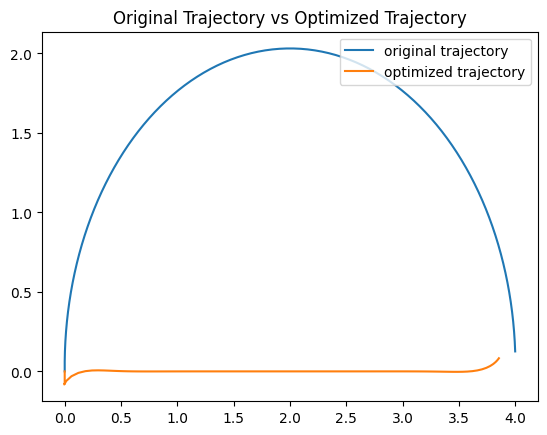

In [25]:
plt.plot(P0[:,0], P0[:,1], label = 'original trajectory')
plt.plot(xi[:,0], xi[:,1], label = 'optimized trajectory')
plt.title("Original Trajectory vs Optimized Trajectory")
plt.legend(loc = 1)
#plt.plot(t, xi[:,1], label = 'x(t)')
#plt.plot(t, xi[:,2], label = 'x(t)')
#plt.plot(t, xi[:,3], label = 'x(t)')
#plt.plot(t, xi[:,4], label = 'x(t)')


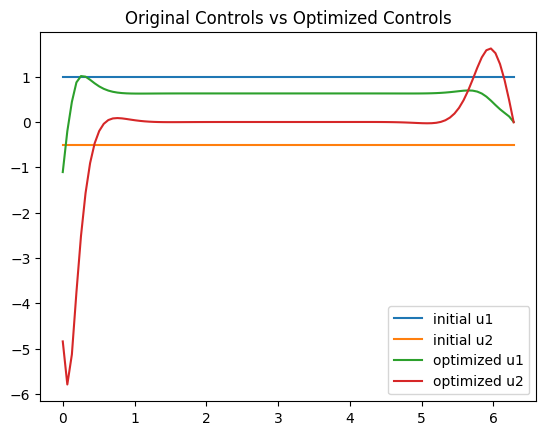

In [26]:
plt.plot(t, P0[:,3], label = "initial u1")
plt.plot(t, P0[:,4], label = "initial u2")
plt.plot(t, xi[:,3], label = 'optimized u1')
plt.plot(t, xi[:,4], label = 'optimized u2')
plt.title("Original Controls vs Optimized Controls")
plt.legend()

In [30]:
J(P0)

707.8221441851915

In [31]:
DJ(P0, z, v)

-0.012797224991500492